In [1]:
# modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor as flr

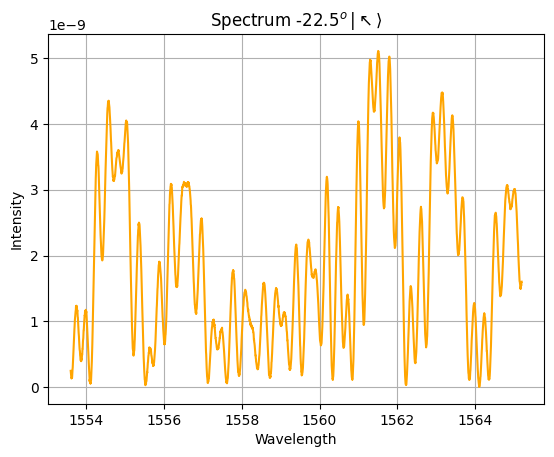

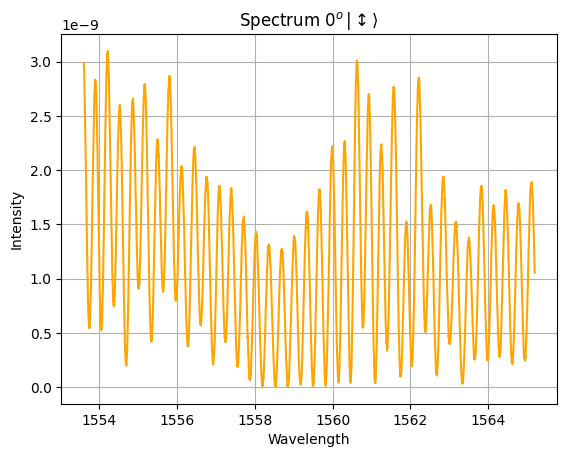

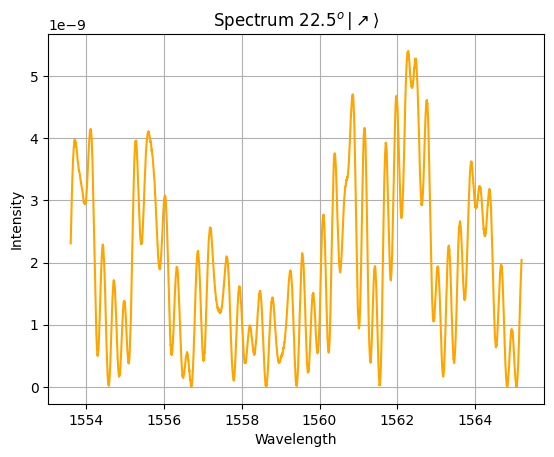

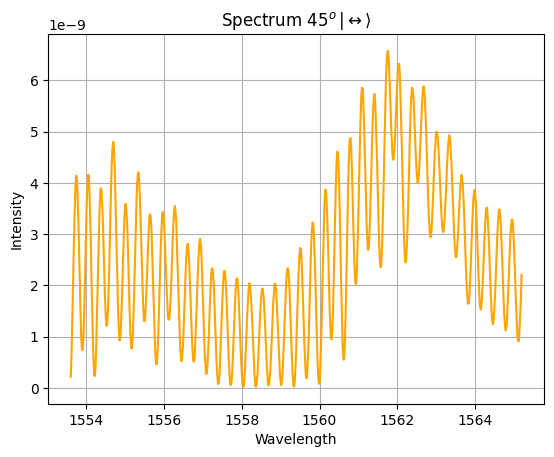

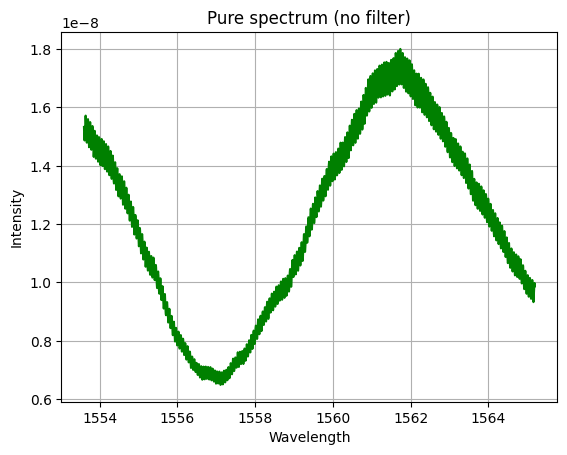

In [2]:
# load spectres

spectre_bit_left = pd.read_table("-22_5_shear_07_nm.dat", skiprows = 2)
spectre_centre = pd.read_table("0_shear_07_nm.dat", skiprows = 2)
spectre_bit_right = pd.read_table("22_5_shear_07_nm.dat", skiprows = 2)
spectre_right = pd.read_table("45_shear_07_nm.dat", skiprows = 2)

# let's remove trash data

spectres = []
spectres_names = [r"Spectrum -22.5$^o\,|\nwarrow\rangle$", r"Spectrum 0$^o\,|\updownarrow\rangle$", r"Spectrum 22.5$^o\,|\nearrow\rangle$", r"Spectrum 45$^o\,|\leftrightarrow\rangle$"]

for s in [spectre_bit_left, spectre_centre, spectre_bit_right, spectre_right]:
    data = s.values[900:3800, :]
    s = pd.DataFrame(data)
    spectres.append(s)

# load pure spectrum as reference

pure = pd.read_table("Pure_spectrum.dat", skiprows = 2)
data = pure.values[26900:29800:1, :]
pure = pd.DataFrame(data)

# plot everything

for i in range(4):
    plt.plot(spectres[i].values[:, 0], spectres[i].values[:, 1], color = "orange")
    plt.title(spectres_names[i])
    plt.xlabel("Wavelength")
    plt.ylabel("Intensity")
    plt.grid()
    plt.show()

plt.plot(pure.values[:,0], pure.values[:,1], color = "green")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.title("Pure spectrum (no filter)")
plt.grid()
plt.show()

In [3]:
# very nice, now we want to find time delays in spectres 1 and 3
# hopefully the difference between delays will be something like 2 ps

# firstly we need to improve visibility of fringes

def make_it_visible(spectrum, sample_rate):

    wl = spectrum.values[:, 0]
    intens = spectrum.values[:, 1]

    minima = []
    samples_num = len(intens) // sample_rate + 1

    # find "local" minima

    for i in range(samples_num):
        start = sample_rate*i
        end = sample_rate*(i+1)

        if start >= len(intens): break

        if end > len(intens) - 1:
            end = len(intens)

        minimum = np.min(intens[start: end])
        minima.append(minimum)

    # subtract the minima

    new_intens = []
    for i in range(len(intens)):
        new =  intens[i] - minima[flr(i/sample_rate)]
        new_intens.append(new)

    # and return a nice dataframe

    return pd.DataFrame(np.array([[wl[i], new_intens[i]] for i in range(len(wl))]))

spectrum_1_norm = make_it_visible(spectres[1], 80)
spectrum_3_norm = make_it_visible(spectres[3], 75)

# cool, time for finding fringes period

def find_period(spectrum, height = 1, hist = False):
    wl = spectrum.values[:, 0]
    intens = spectrum.values[:, 1]
    h = height * np.mean(intens)
    nodes = []

    for i in range(2, len(intens) - 2):
        # decreasing
        if intens[i-2] > intens[i-1] > h > intens[i] > intens[i+1] > intens[i+2]:
            nodes.append(wl[i])

    diff = np.diff(np.array(nodes))

    if hist:
        plt.hist(diff, color = "orange")
        plt.xlabel("Period length [nm]")
        plt.ylabel("Counts")
        plt.show()

    mean = np.mean(diff)
    std = np.std(diff)
    diff_cut = [d for d in diff if np.abs(d - mean) < std]
    
    return np.mean(diff_cut), np.std(diff_cut)

# and let's apply it to our spectres

mean1, std1 = find_period(spectrum_3_norm)
del1 = 8/mean1
unc1 = round(std1*8/mean1/mean1, 2)

mean2, std2 = find_period(spectrum_1_norm)
del2 = 8/mean2
unc2 = round(std2*8/mean2/mean2, 2)

print("W widmie 0 stopni, dwie wiązki lasera były opóźnione o " + str(round(del1, 2)) + " +- " + str(unc1) + " ps.")
print("W widmie 45 stopni, dwie wiązki lasera były opóźnione o " + str(round(del2, 2)) + " +- " + str(unc2) + " ps.")
print("Różnica opóźnień między widmami była równa " + str(round(abs(del1-del2), 2)) + " +- " + str(round((unc1+unc2)/1.41, 2)) + " ps.")


W widmie 0 stopni, dwie wiązki lasera były opóźnione o 25.13 +- 1.13 ps.
W widmie 45 stopni, dwie wiązki lasera były opóźnione o 25.1 +- 1.38 ps.
Różnica opóźnień między widmami była równa 0.03 +- 1.78 ps.


Co w sumie ma spory sens, bo ten kąt nie określa półfalówki przed klinami a półfalówki przed PBS-em, więc w obu przypadkach opóźnienie było to samo, tylko wiązki były mieszane na innych osiach ukośnych. Dobrze wiedzieć, że fizyka działa.

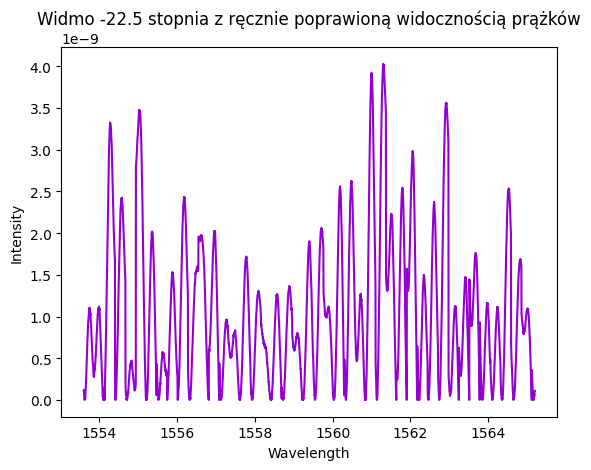

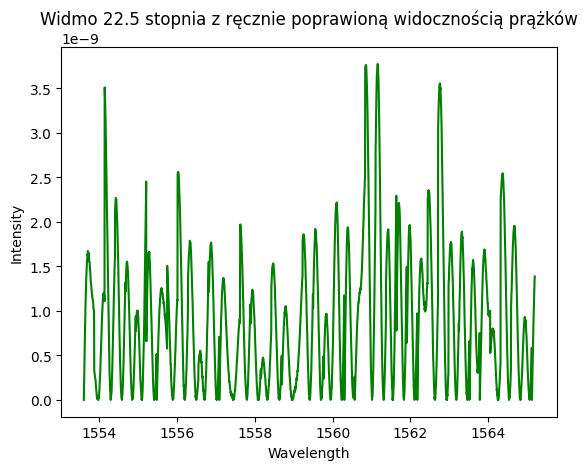

W widmie -22.5 stopnia, dwie wiązki lasera były opóźnione o 24.8 +- 6.2 ps.
W widmie 22.5 stopni, dwie wiązki lasera były opóźnione o 27.1 +- 4.7 ps.
Różnica opóźnień między widmami była równa 2.3 +- 7.7ps.


In [4]:
# możemy teraz sprawdzić co się stanie jak poprawimy widoczność widm "pojedynczych" impulsów i obliczymy opóźnienie

spectrum_0_norm = make_it_visible(spectres[0], 67)
spectrum_2_norm = make_it_visible(spectres[2], 67)

plt.plot(spectrum_0_norm.values[:,0], spectrum_0_norm.values[:,1], color = "darkviolet")
plt.title("Widmo -22.5 stopnia z ręcznie poprawioną widocznością prążków")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.show()

plt.plot(spectrum_2_norm.values[:,0], spectrum_2_norm.values[:,1], color = "green")
plt.title("Widmo 22.5 stopnia z ręcznie poprawioną widocznością prążków")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.show()

mean1, std1 = find_period(spectrum_0_norm)
del1 = 8/mean1
unc1 = round(std1*8/mean1/mean1, 1)

mean2, std2 = find_period(spectrum_2_norm)
del2 = 8/mean2
unc2 = round(std2*8/mean2/mean2, 1)


print("W widmie -22.5 stopnia, dwie wiązki lasera były opóźnione o " + str(round(del1, 1)) + " +- " + str(unc1) + " ps.")
print("W widmie 22.5 stopni, dwie wiązki lasera były opóźnione o " + str(round(del2, 1)) + " +- " + str(unc2) + " ps.")
print("Różnica opóźnień między widmami była równa " + str(round(abs(del1-del2), 1)) + " +- " + str(round((unc1+unc2)/1.41, 1)) + "ps.")

Przy czym powyższe obliczenie opóźnienia ma sens co do rzędu wielkości, bo jego dokładna wielkość zależała mocno od tego jak poprawiana była widoczność prążków.

In [5]:
# there are some fringes also in pure spectrum, let's calculate the delay

pure_norm = make_it_visible(pure, 12)
mean, std = find_period(pure_norm)
delay = 8/mean
delay_unc = std*8/mean/mean

print("W czystym widmie (hipotetyczne) dwa impulsy są opóźnione o {} +- {} ps.".format(round(delay, 1), round(delay_unc, 1)))

W czystym widmie (hipotetyczne) dwa impulsy są opóźnione o 136.4 +- 7.5 ps.


In [6]:
# dobra, to jakaś szybka całka z intensywności

for i in range(4):
    print("Całkowita intensywność widma \"" + spectres_names[i] + "\" to " + str(round(sum(spectres[i].values[:,1]), 9)))

print("\nIntensywność w bazie diagonalnej to {}.".format(round(sum(spectres[0].values[:,1]) + sum(spectres[2].values[:,1]), 9)))
print("Intensywność w bazie pionowo-poziomej to {}.".format(round(sum(spectres[1].values[:,1]) + sum(spectres[3].values[:,1]), 9)))

Całkowita intensywność widma "Spectrum -22.5$^o\,|\nwarrow\rangle$" to 5.33e-06
Całkowita intensywność widma "Spectrum 0$^o\,|\updownarrow\rangle$" to 3.445e-06
Całkowita intensywność widma "Spectrum 22.5$^o\,|\nearrow\rangle$" to 5.601e-06
Całkowita intensywność widma "Spectrum 45$^o\,|\leftrightarrow\rangle$" to 7.312e-06

Intensywność w bazie diagonalnej to 1.093e-05.
Intensywność w bazie pionowo-poziomej to 1.0757e-05.


Na osiach ukośnych mamy rozkład intensywności na obu polaryzacjach w stosunku 19:20. <br>
Na osiach głównych jest to już 9:20. <br>
W obu bazach mamy spodziewany wynik - intensywności na obu polaryzacjach prostopadłych dodają się do prawie tej samej liczby. <br>
<br>
Z jednej strony wniosek, że coś średnio ustaliłeś płytkę falową na filtrze - bo tylko tam mogły być straty mocno zależne od polaryzacji. Z drugiej pociecha, że osie ukośne są całkiem dobrą mieszanką, a osie główne to rzeczywiście pojedyncze impulsy.

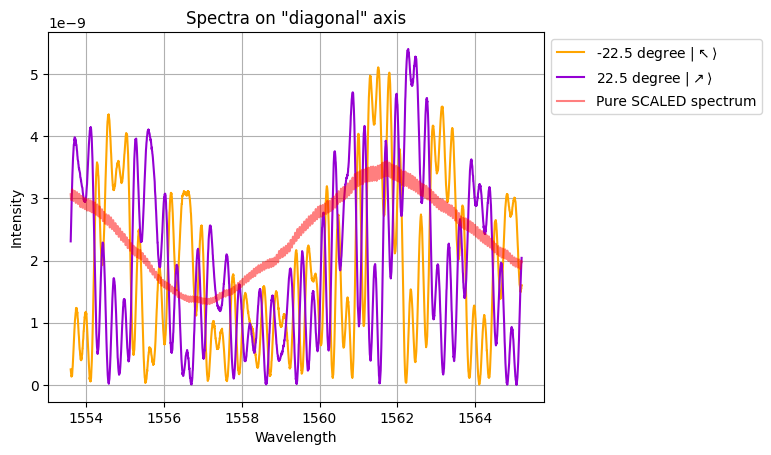

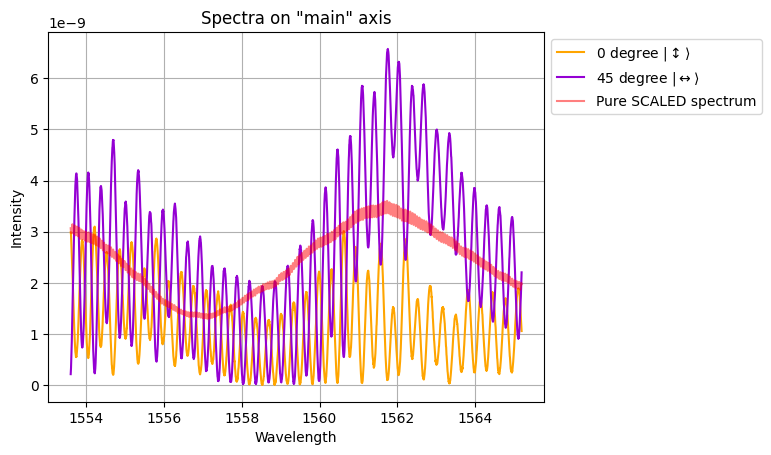

In [7]:
# to jeszcze wyplotujmy impuls i impuls shearowany

k = 0.5
intensity_one = k*spectres[0].values[:, 1] + (1-k)*spectres[3].values[:, 1]
intensity_two = k*spectres[2].values[:, 1] + (1-k)*spectres[1].values[:, 1]

intens_sum_1 = spectres[0].values[:, 1] + spectres[2].values[:, 1]
intens_sum_2 = spectres[1].values[:, 1] + spectres[3].values[:, 1]

start = 0
end = 2900 # max 2900

i = 0
j = 2

plt.plot(spectres[i].values[start:end, 0], spectres[0].values[start:end, 1], color = "orange")
plt.plot(spectres[j].values[start:end, 0], spectres[2].values[start:end, 1], color = "darkviolet")
plt.plot(pure.values[start:end, 0], 0.2*pure.values[start:end, 1], color = "red", alpha = 0.5)
plt.title("Spectra on \"diagonal\" axis")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.legend([r"-22.5 degree $ | \nwarrow \rangle $", r"22.5 degree $| \nearrow \rangle$", "Pure SCALED spectrum"], bbox_to_anchor = [1, 1])
plt.grid()
plt.show()

plt.plot(spectres[i].values[start:end, 0], spectres[1].values[start:end, 1], color = "orange")
plt.plot(spectres[j].values[start:end, 0], spectres[3].values[start:end, 1], color = "darkviolet")
plt.plot(pure.values[start:end, 0], 0.2*pure.values[start:end, 1], color = "red", alpha = 0.5)

plt.title("Spectra on \"main\" axis")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.legend([r"0 degree $| \updownarrow \rangle$", r"45 degree $| \leftrightarrow \rangle$", "Pure SCALED spectrum"], bbox_to_anchor = [1, 1])
plt.grid()
plt.show()

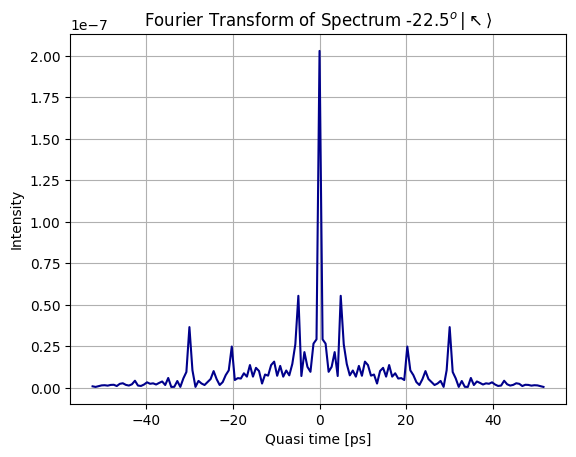

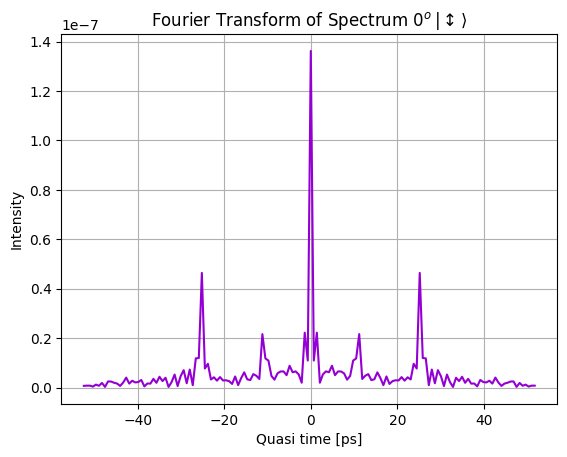

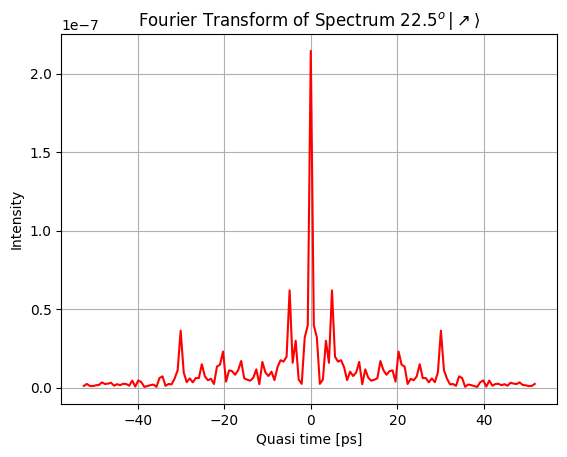

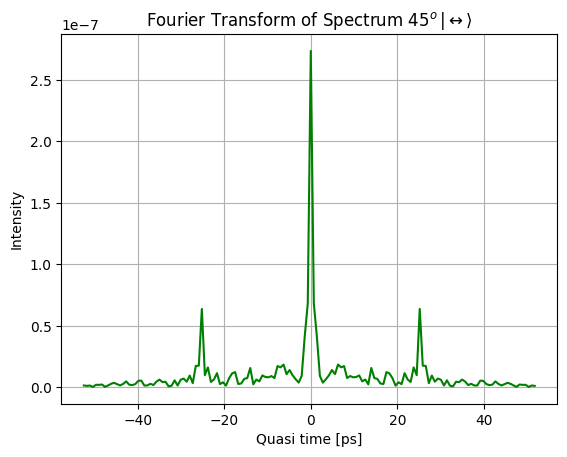

In [8]:
import spectral_analysis as sa

colors = ["darkblue", "darkviolet", "red", "green"]
for i in range(4):
    spectrum = spectres[i]

    freq_spectrum = sa.wl_to_freq(spectrum)
    const_spectrum = sa.constant_spacing(freq_spectrum)
    ft_spectrum = sa.fourier(const_spectrum, absolute = True)

    start = 1375
    end = 1525

    plt.plot(ft_spectrum.values[start:end, 0], ft_spectrum.values[start:end, 1], color = colors[i])
    plt.xlabel("Quasi time [ps]")
    plt.ylabel("Intensity")
    plt.title("Fourier Transform of " + spectres_names[i])
    plt.grid()
    plt.show()

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


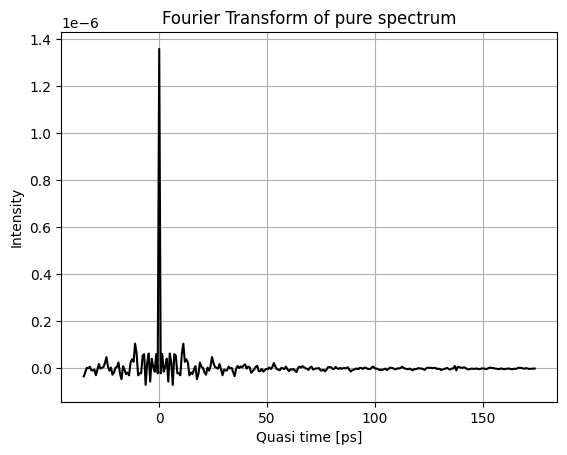

In [9]:
freq_spectrum = sa.wl_to_freq(pure)
const_spectrum = sa.constant_spacing(freq_spectrum)
ft_spectrum = sa.fourier(const_spectrum)

start = 1400
end = 1700

plt.plot(ft_spectrum.values[start:end, 0], ft_spectrum.values[start:end, 1], color = "black")
plt.xlabel("Quasi time [ps]")
plt.ylabel("Intensity")
plt.title("Fourier Transform of pure spectrum")
plt.grid()
plt.show()